# Predicting BSE Sensex

Yes, you heard it right! 

**"Predicting Sensex".** 

Can we even do it? I mean, is it really possible?

I know, these questions are genuine and in a way stand right on its own. 

Closing prices or returns on stock prices or closing values of market as a whole is a kind of stochastic time-series which in technical term is classified under "general random_walk". This is a non-stationary time series which means its mean or other statistical properties change over time.

Predicting future steps of a random walk time series is really a formidable task. In nut-shell, this seems an unsolvable problem.

This is my humble attempt to look this problem from a different perspective.

I have been a student and practisioner of Machine Learning since a while now, so I thought why dont we try to find the solution of predicting sensex returns through the methods of Machine Learning.

*A word of caution*: 

There can be some obvious pitfalls which we should be wary of:

1. It is really a difficult problem to solve even through the methods of Machine Learning. However, there have been few exciting developments to solve this problem with the help of advanced techniques such as LSTM. In this module, I have not implemented any deep learning methods but planning to do it shortly. So if ever I will write another similar project document, I will try to mention about the results of this exercise.


2. We will shortly find that "lag" (remember : ARIMA, SARIMA models in time series) is an extremely important feature while predicting future returns. The shorter the lag period we will choose in our model, better the predictions will be. But this means we are just looking immediate back in past and trying to predict immediate future value. This means we may overfit the model. On the other hand, choosing a higher lag period will worsen the predictions.

So, what are we waiting for!

Lets dive in!

First we will import all tools in Python!

## Loading Libraries and Data

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

import warnings
warnings.filterwarnings('ignore')

# loading basic ML algoriths
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# few powerful algorithms as well which we will see later dont perform well compared to basic algorithms
import xgboost
import lightgbm

# load the downloaded data
import os
os.chdir('D:\\Machine Learning - mlcourse.ai\\mlcourse.ai\\mlcourse.ai-master\\data')

In [2]:
# load the data into pandas dataframe
df = pd.read_csv('BSESN.csv')
df.head()

# since there are few NaN values, we should remove these first
df.dropna(axis=0, inplace=True)

# Lets check the data once again
df.head(6)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,4263.109863,4301.770020,4247.660156,4300.859863,4300.859863,0.0
1,1997-07-02,4302.959961,4395.310059,4295.399902,4333.899902,4333.899902,0.0
2,1997-07-03,4335.790039,4393.290039,4299.970215,4323.459961,4323.459961,0.0
3,1997-07-04,4332.700195,4347.589844,4300.580078,4323.819824,4323.819824,0.0
4,1997-07-07,4326.810059,4391.009766,4289.490234,4291.450195,4291.450195,0.0
5,1997-07-08,4285.649902,4313.000000,4252.490234,4306.390137,4306.390137,0.0


In [3]:
# We now need to convert the Dates into Pandas Date format
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

# Better to check the data once again
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1997-07-01,1997-07-01,4263.109863,4301.770020,4247.660156,4300.859863,4300.859863,0.0
1997-07-02,1997-07-02,4302.959961,4395.310059,4295.399902,4333.899902,4333.899902,0.0
1997-07-03,1997-07-03,4335.790039,4393.290039,4299.970215,4323.459961,4323.459961,0.0
1997-07-04,1997-07-04,4332.700195,4347.589844,4300.580078,4323.819824,4323.819824,0.0
1997-07-07,1997-07-07,4326.810059,4391.009766,4289.490234,4291.450195,4291.450195,0.0


OK, so what have we done so far:

1. Imported all libraries
2. Loaded the BSE Sensex Data from year 1997 which I downloaded earlier from Yahoo Finance. This means we have data of every day when market was open for almost 21 years.
3. Did some basic formatting

Now, before going forward, we have two choices for target variable (the thing which we are trying to predict):

1. Close prices (unadjusted price) - this is not adjusted for any corporate action. By corporate actions, I mean, dividends, stock splits, buybacks etc. This is not useful for us as this will not give a clear picture of what happened to Sensex over the years.


2. Adjusted Close prices - this is adjusted for almost all major corporate actions (dividends paid + stock splits). We will use this for our target.

## EDA and Feature Engineering

In [4]:
# Plot the Graph for Adjusted Closing Price

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=df.Date,
    y=df['Adj Close'],
    name='Closing Price'
)
data = [trace1]
layout = {'title': 'Adjusted Closing Price'}
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [5]:
# Shape of the Data
print(df.shape)

# Lets create a new dataset in which we will only store the required inputs.

#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Adj Close'][i]    

# Lets check the Data once again
new_data.head()

(5293, 7)


,Date,Close
0,1997-07-01 00:00:00,4300.86
1,1997-07-02 00:00:00,4333.9
2,1997-07-03 00:00:00,4323.46
3,1997-07-04 00:00:00,4323.82
4,1997-07-07 00:00:00,4291.45


So, here we have shrugged off all undesirable features and retained only Dates and Adjusted Closing prices.

But this wont be all. We will create a number of features (just based on dates). Can you think of any important feature which we can create on dates and I missed it? 

In [6]:
# We will create a number of features on the Dates

new_data['year'] = new_data['Date'].map(lambda x : x.year)
new_data['month'] = new_data['Date'].map(lambda x : x.month)
new_data['day_week'] = new_data['Date'].map(lambda x : x.dayofweek)
new_data['quarter'] = new_data['Date'].map(lambda x : x.quarter)
new_data['week'] = new_data['Date'].map(lambda x : x.week)
new_data['quarter_start'] = new_data['Date'].map(lambda x : x.is_quarter_start)
new_data['quarter_end'] = new_data['Date'].map(lambda x : x.is_quarter_end)
new_data['month_start'] = new_data['Date'].map(lambda x : x.is_month_start)
new_data['month_end'] = new_data['Date'].map(lambda x : x.is_month_end)
new_data['year_start'] = new_data['Date'].map(lambda x : x.is_year_start)
new_data['year_end'] = new_data['Date'].map(lambda x : x.is_year_end)
new_data['week_year'] = new_data['Date'].map(lambda x : x.weekofyear)
new_data['quarter_start'] = new_data['quarter_start'].map(lambda x: 0 if x is False else 1)
new_data['quarter_end'] = new_data['quarter_end'].map(lambda x: 0 if x is False else 1)
new_data['month_start'] = new_data['month_start'].map(lambda x: 0 if x is False else 1)
new_data['month_end'] = new_data['month_end'].map(lambda x: 0 if x is False else 1)
new_data['year_start'] = new_data['year_start'].map(lambda x: 0 if x is False else 1)
new_data['year_end'] = new_data['year_end'].map(lambda x: 0 if x is False else 1)
new_data['day_month'] = new_data['Date'].map(lambda x: x.daysinmonth)

# Create a feature which could be important - Markets are only open between Monday and Friday.
mon_fri_list = [0,4]
new_data['mon_fri'] = new_data['day_week'].map(lambda x: 1 if x in mon_fri_list  else 0)

# It has been proved in many studies worldwide that winters are better for return on stocks than summers. 
# We will see how true is this in this case.

second_half = [7, 8, 9, 10, 11, 12]
new_data['half_year'] = new_data['month'].map(lambda x: 1 if x in second_half  else 0)

In [7]:
# Re-indexing the data
new_data.index = new_data['Date']
new_data.drop('Date', inplace=True, axis=1)

new_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5293 entries, 1997-07-01 to 2018-12-19
Data columns (total 16 columns):
Close            5293 non-null object
year             5293 non-null int64
month            5293 non-null int64
day_week         5293 non-null int64
quarter          5293 non-null int64
week             5293 non-null int64
quarter_start    5293 non-null int64
quarter_end      5293 non-null int64
month_start      5293 non-null int64
month_end        5293 non-null int64
year_start       5293 non-null int64
year_end         5293 non-null int64
week_year        5293 non-null int64
day_month        5293 non-null int64
mon_fri          5293 non-null int64
half_year        5293 non-null int64
dtypes: int64(15), object(1)
memory usage: 703.0+ KB


In [8]:
new_data["Close"] = pd.to_numeric(new_data["Close"],errors='coerce')

## Plots Plots and... Plots

In [9]:
import seaborn as sns
sns.set_style("whitegrid")
sns.despine(left=True)

<Figure size 432x288 with 0 Axes>

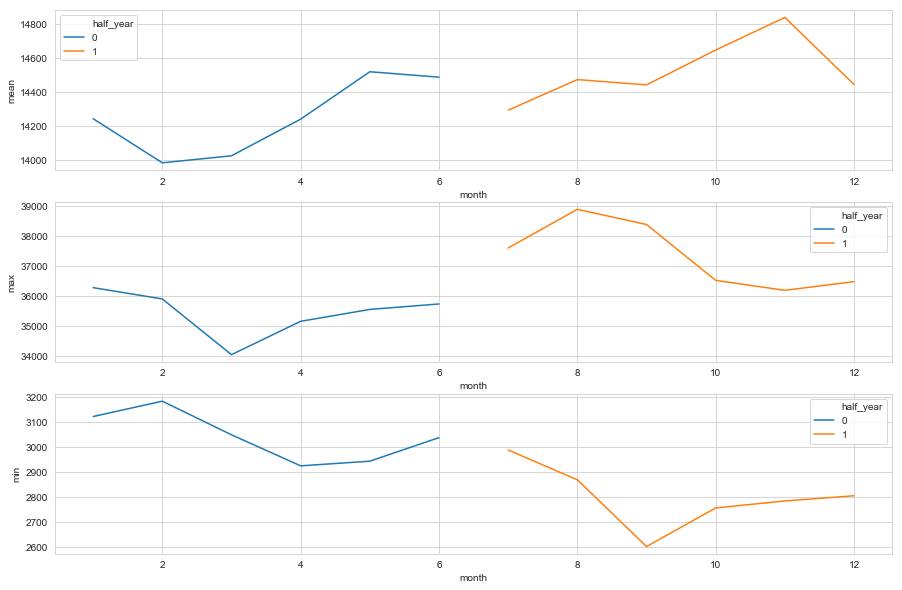

In [10]:
df_1 = pd.DataFrame(new_data.groupby(['half_year','month'])['Close'].agg(['mean','max', 'min']))
df_1.reset_index(inplace=True)

f, axes = plt.subplots(3,1, figsize=(15,10))

sns.lineplot(x='month', y ='mean', hue='half_year', data=df_1,ax=axes[0])
sns.lineplot(x='month', y ='max', hue='half_year', data=df_1, ax=axes[1])
sns.lineplot(x='month', y ='min', hue='half_year',data=df_1, ax=axes[2])

Yep! Mean values of Closing Prices in winters is higher than those of summers. So guys, lets wait for summers to buy few stocks..

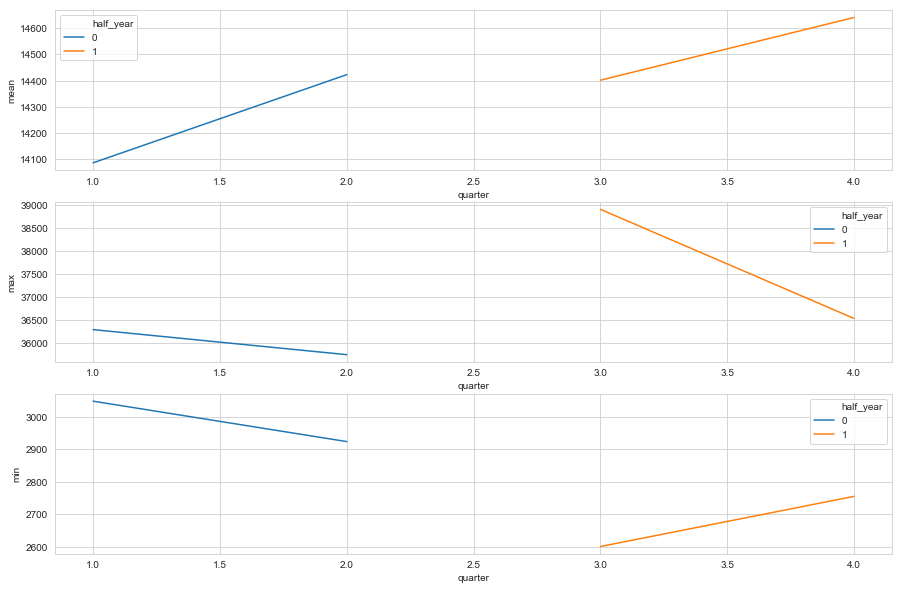

In [11]:
df_2 = pd.DataFrame(new_data.groupby(['half_year','quarter'])['Close'].agg(['mean','max', 'min']))
df_2.reset_index(inplace=True)

f, axes = plt.subplots(3,1, figsize=(15,10))

sns.lineplot(x='quarter', y ='mean', hue='half_year', data=df_2,ax=axes[0])
sns.lineplot(x='quarter', y ='max',hue='half_year', data=df_2, ax=axes[1])
sns.lineplot(x='quarter', y ='min', hue='half_year', data=df_2, ax=axes[2])

This is the same thing which I mentioned before but represented in quarterly fashion

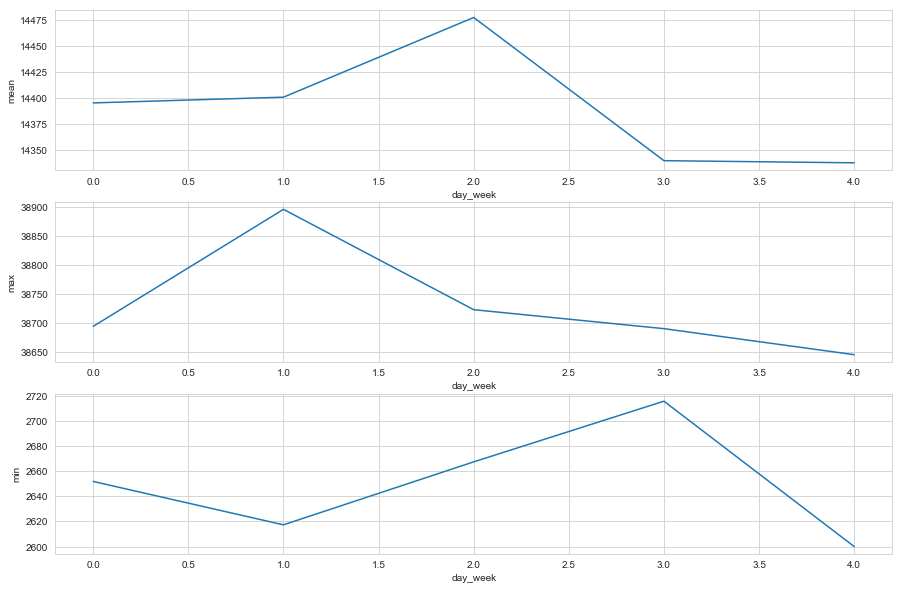

In [12]:
df_3 = pd.DataFrame(new_data.groupby(['day_week'])['Close'].agg(['mean','max', 'min']))
df_3.reset_index(inplace=True)

f, axes = plt.subplots(3,1, figsize=(15,10))

sns.lineplot(x='day_week', y ='mean',  data=df_3,ax=axes[0])
sns.lineplot(x='day_week', y ='max',  data=df_3, ax=axes[1])
sns.lineplot(x='day_week', y ='min',  data=df_3, ax=axes[2])

Ok, we all know this - Friday effect! Or rather, inverse of Friday effect.. On Mondays sensex is on average higher than on Fridays.. strange!

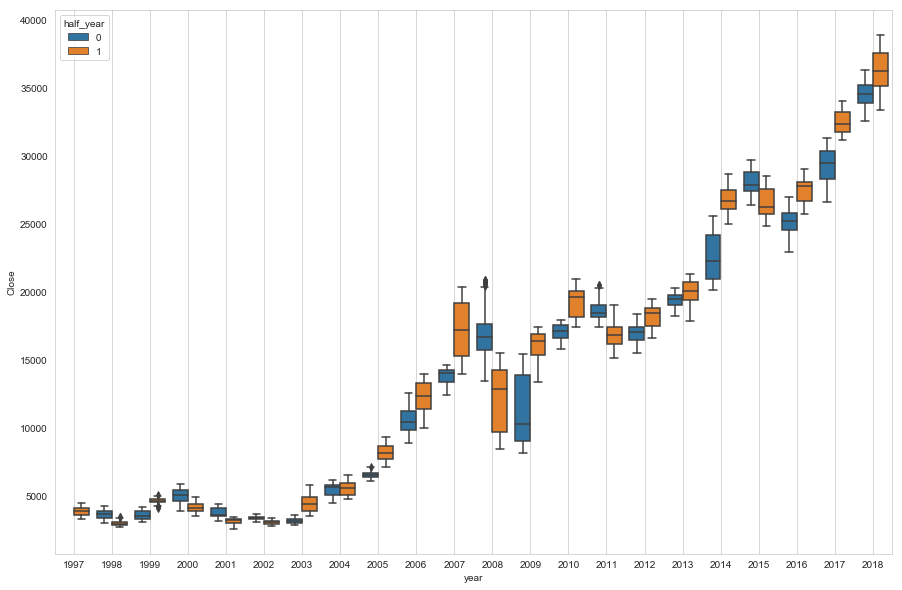

In [13]:
plt.figure(figsize=(15,10))
sns.boxplot(x=new_data['year'], y =new_data['Close'], hue=new_data['half_year'])
plt.grid()

This is my fav one!

You can clearly see that in recent years, in second half of the year, sensex surges ahead compared to the first half.

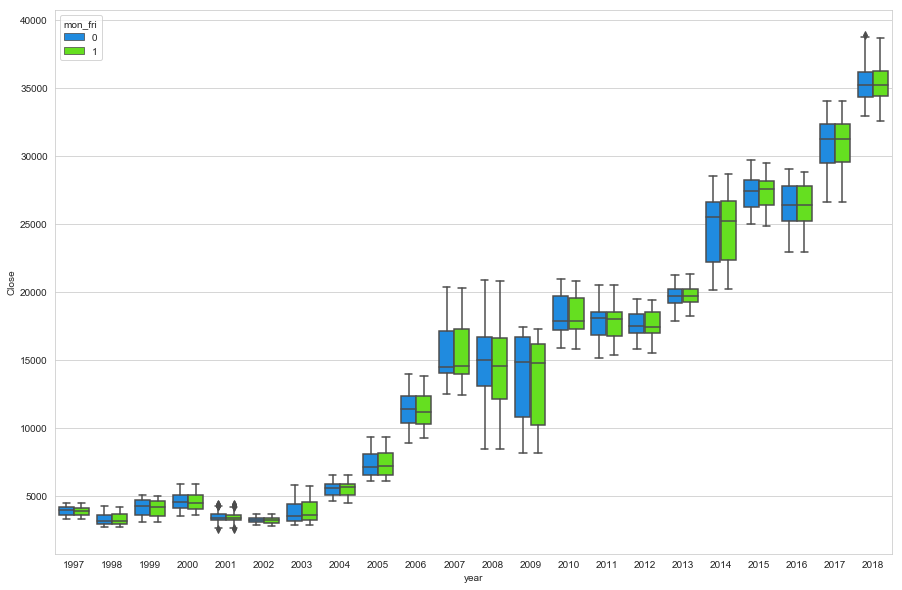

In [14]:
plt.figure(figsize=(15,10))
sns.boxplot(x="year", y="Close", hue="mon_fri", palette='gist_rainbow_r',data=new_data)

Not much info from above or below graphs! But these lool cools so did not delete them! :)

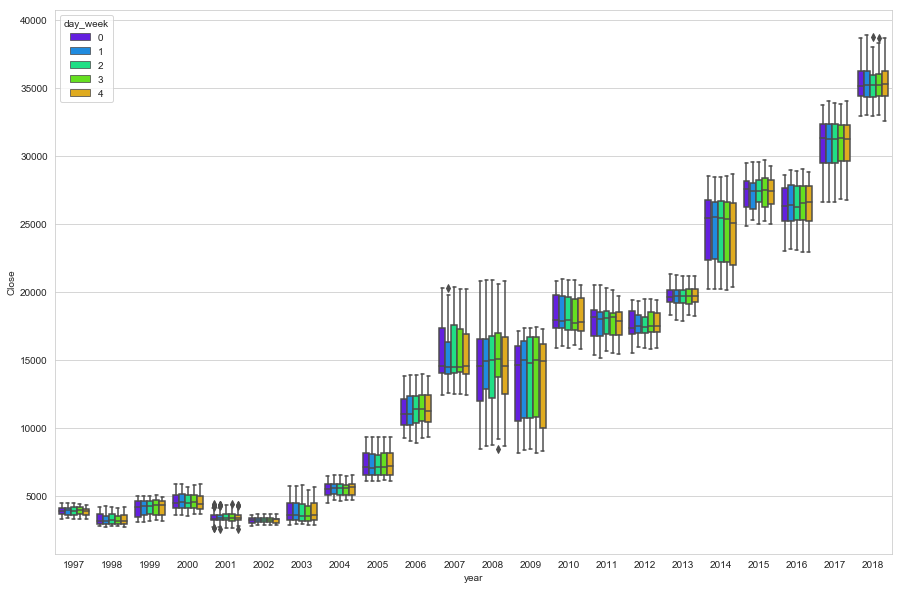

In [15]:
plt.figure(figsize=(15,10))
sns.boxplot(x="year", y="Close", hue="day_week", palette='gist_rainbow_r',data=new_data)

Now we will see how the curves get smoother if we see it in monthly values, quarterly values and yearly values.

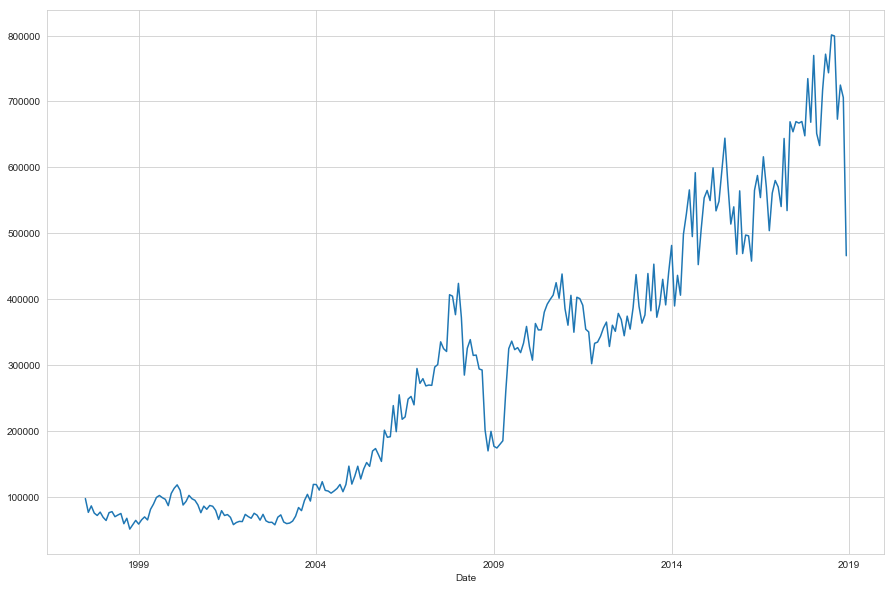

In [16]:
monthly = new_data['Close'].resample('M').sum()
plt.figure(figsize=(15,10))
monthly.plot()

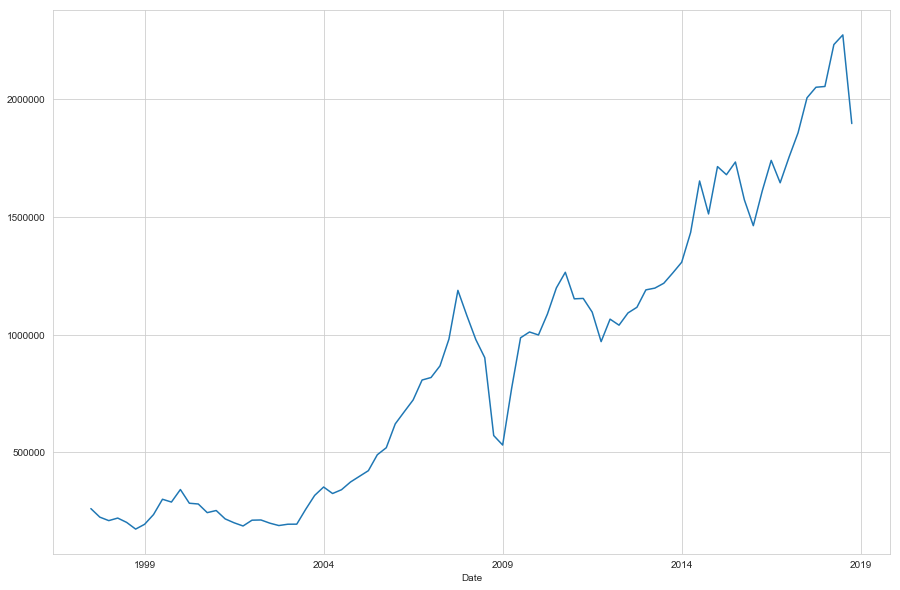

In [17]:
quarterly = new_data['Close'].resample('Q').sum()
plt.figure(figsize=(15,10))
quarterly.plot()

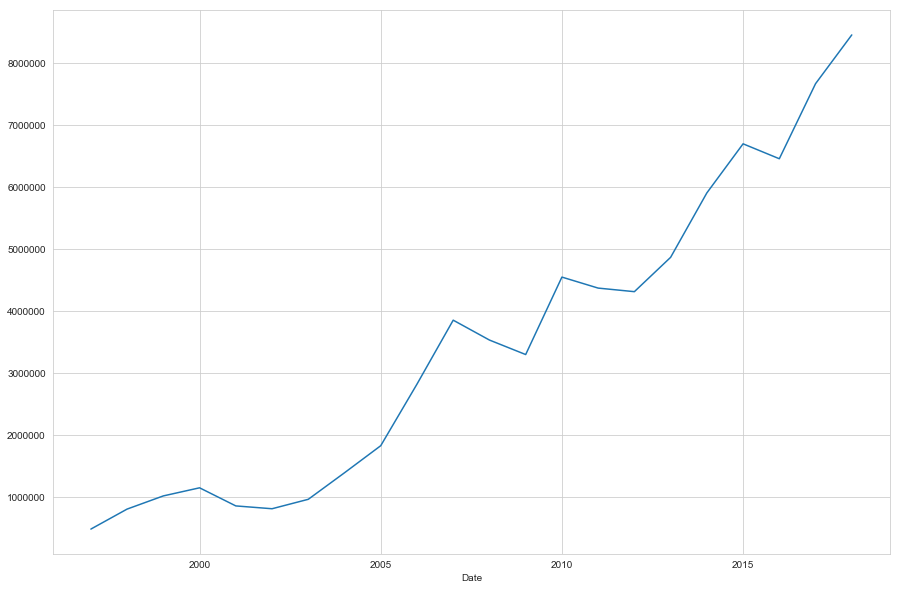

In [18]:
yearly = new_data['Close'].resample('Y').sum()
plt.figure(figsize=(15,10))
yearly.plot()

30 days moving avearge plot

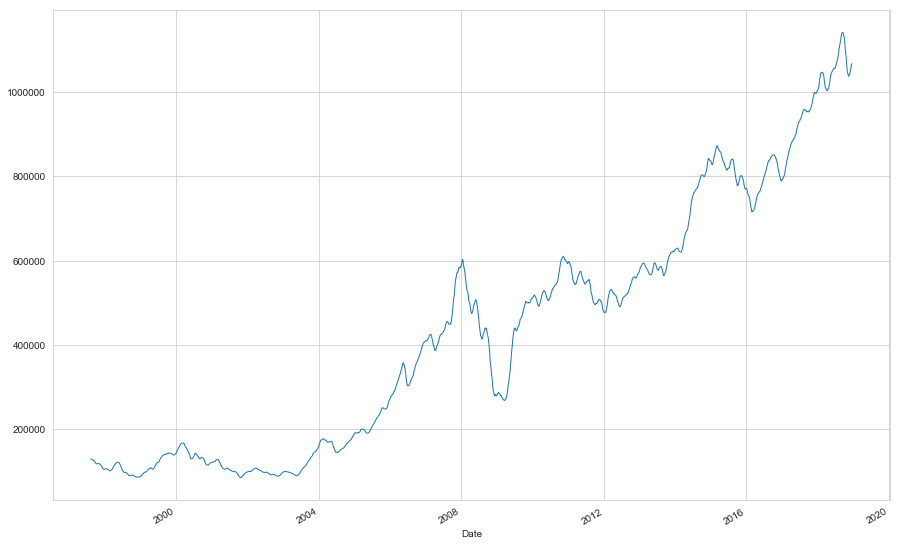

In [19]:
new_data['Close'].rolling(30).sum().plot(figsize=(15,10), linewidth=1)

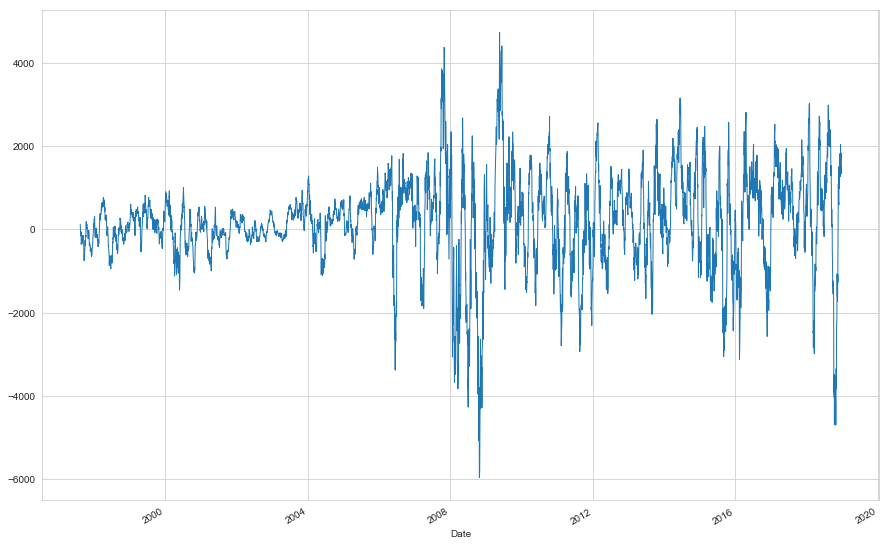

In [20]:
new_data['Close'].diff(periods=30).plot(figsize=(15,10), linewidth=1)

Below plot shows that autocorrelation is prominent in our time series. We will see it in details when we reach the SARIMA section.

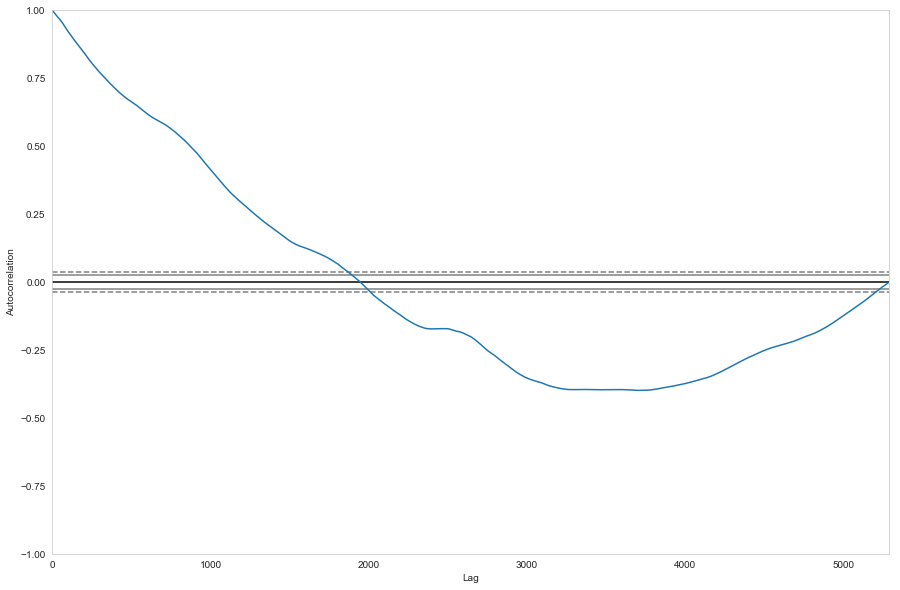

In [21]:
plt.figure(figsize=(15,10))
pd.plotting.autocorrelation_plot(new_data['Close'])

Below plots show the prominence of lags in our time series. Remember, what I said about Lag 1 in introductory section. The effect of lag fades away slowly when we move towards higher lag periods.

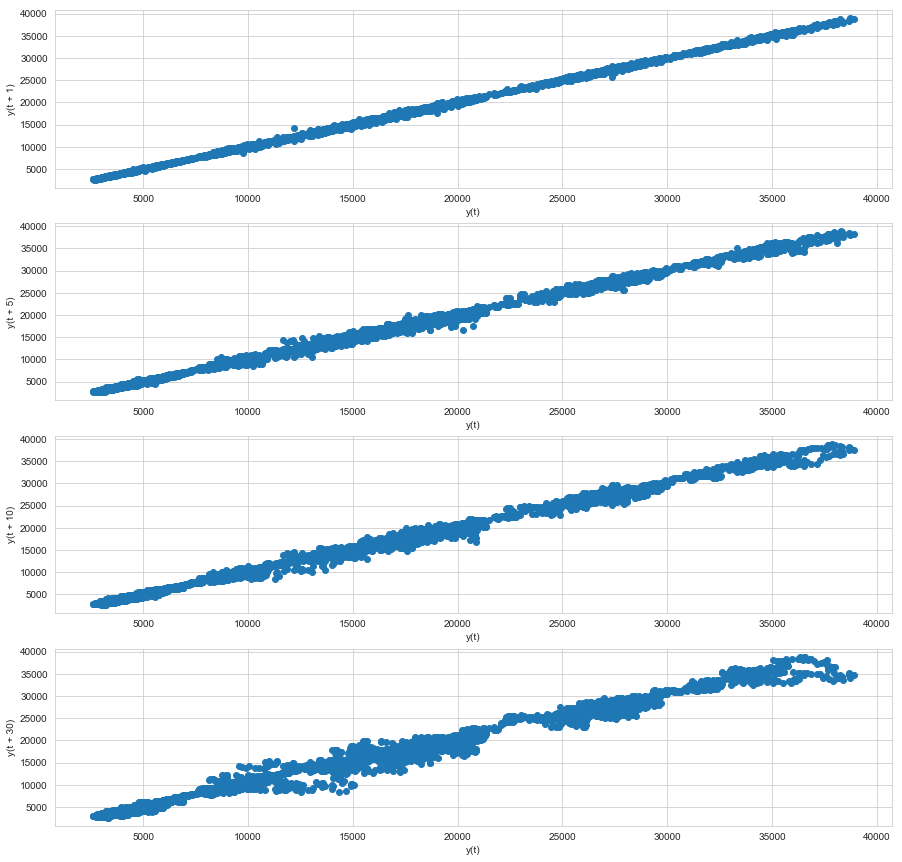

In [22]:
f, axes = plt.subplots(4,1, figsize=(15,15))
pd.plotting.lag_plot(new_data['Close'], lag=1,ax=axes[0])
pd.plotting.lag_plot(new_data['Close'], lag=5, ax=axes[1])
pd.plotting.lag_plot(new_data['Close'], lag=10, ax=axes[2])
pd.plotting.lag_plot(new_data['Close'], lag=30, ax=axes[3])

Below is the Correlation Plot of all features. There are lots of interesting observations here. I wont list them down here. You can see it yourself and deduce some nice observations.

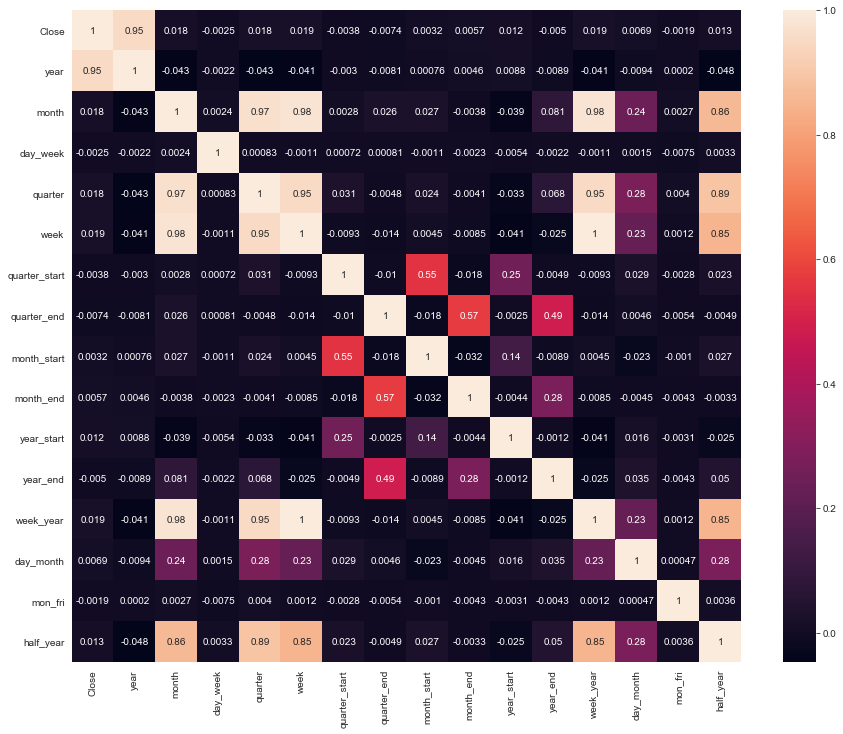

In [23]:
corr_mat = new_data.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr_mat, annot=True)

## Baseline Model (Persistent Model)

First we will create a simple baseline model and see how this performs for our prediction

In [24]:
# Shape of the Data
print(df.shape)

# Lets create a new dataset in which we will only store the required inputs.

#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data_baseline = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data_baseline['Date'][i] = data['Date'][i]
    new_data_baseline['Close'][i] = data['Adj Close'][i]    

# Lets check the Data once again
new_data_baseline.head()

(5293, 7)


,Date,Close
0,1997-07-01 00:00:00,4300.86
1,1997-07-02 00:00:00,4333.9
2,1997-07-03 00:00:00,4323.46
3,1997-07-04 00:00:00,4323.82
4,1997-07-07 00:00:00,4291.45


In [25]:
# dropping date column

new_data_baseline.drop('Date', axis=1, inplace=True)

In [26]:
new_data_baseline['Close-1'] = new_data_baseline.Close.shift(1)
new_data_baseline.head()

,Close,Close-1
0,4300.86,NaN
1,4333.9,4300.86
2,4323.46,4333.9
3,4323.82,4323.46
4,4291.45,4323.82


In [27]:
test_index = int(len(new_data_baseline) * (1 - 0.30))
print(test_index)

train, test = new_data_baseline[1:test_index], new_data_baseline[test_index:]
train_X, train_y = train.iloc[:,0], train.iloc[:,1]
test_X, test_y = test.iloc[:,0], test.iloc[:,1]

3705


In [28]:
## persistent model

def model_persistence(x):
    return x

In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
predictions = list()

for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

test_score_mae = mean_absolute_error(test_y, predictions)
test_score_mape = mean_absolute_percentage_error(test_y, predictions)

print('Test MAE: %.3f' % test_score_mae)
print('Test MAPE: %.3f' % test_score_mape)

Test MAE: 170.540
Test MAPE: 0.654


Great, so our baseline model is predicting MAE and MAPE of around 170 and 0.65.

Lets see what does our complex models predict

Ok, so now real deal. 

Our first prediction model and very widely used in the fields of Econometrics - SARIMA models. Those who dont know, it stands for Seasonal Autoregressive Integrated Moving Averages model. Each word has its own meaning:

1. Seasonal - reflects the seasonality in the data. For example, in case of few stocks, returns can be seasonal.
2. Autoregressive - this states that how does the current or future value of time series depends on its lagged versions.
3. Integrated - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary.
4. Moving average - Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag.

This basic model works quite well but we will see this is not the best one!

## SARIMAX Model

In [31]:
import statsmodels as sm
from statsmodels.graphics import utils
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(15, 12), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        plt.tight_layout()

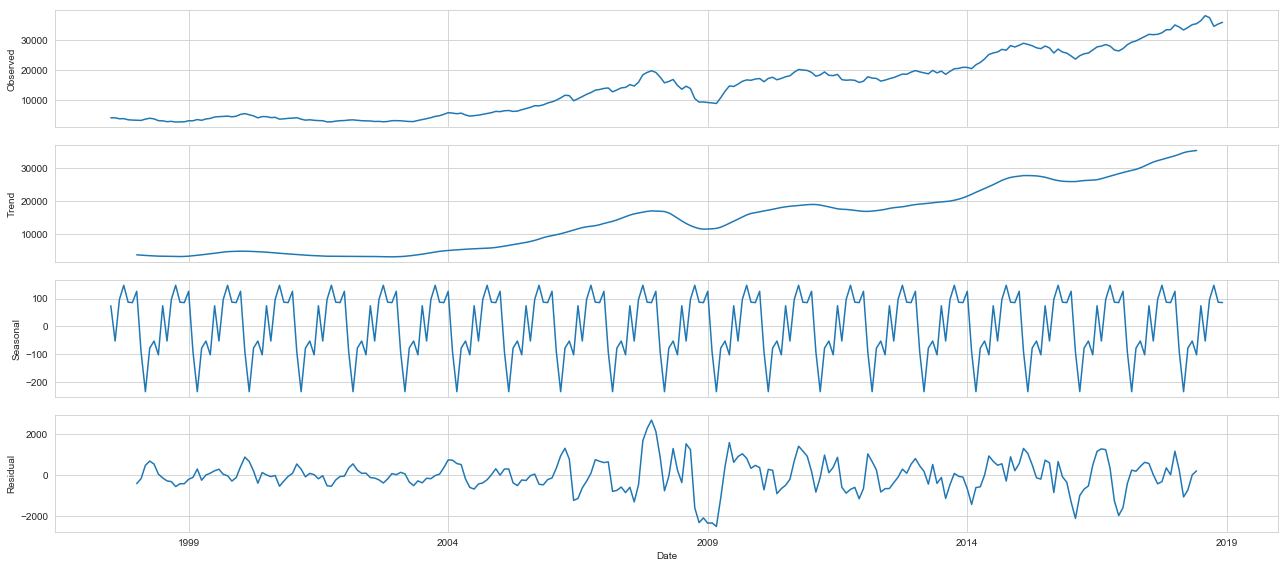

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

y = new_data['Close'].resample('MS').mean()
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Above plot shows the trend and seasonality of the time series.

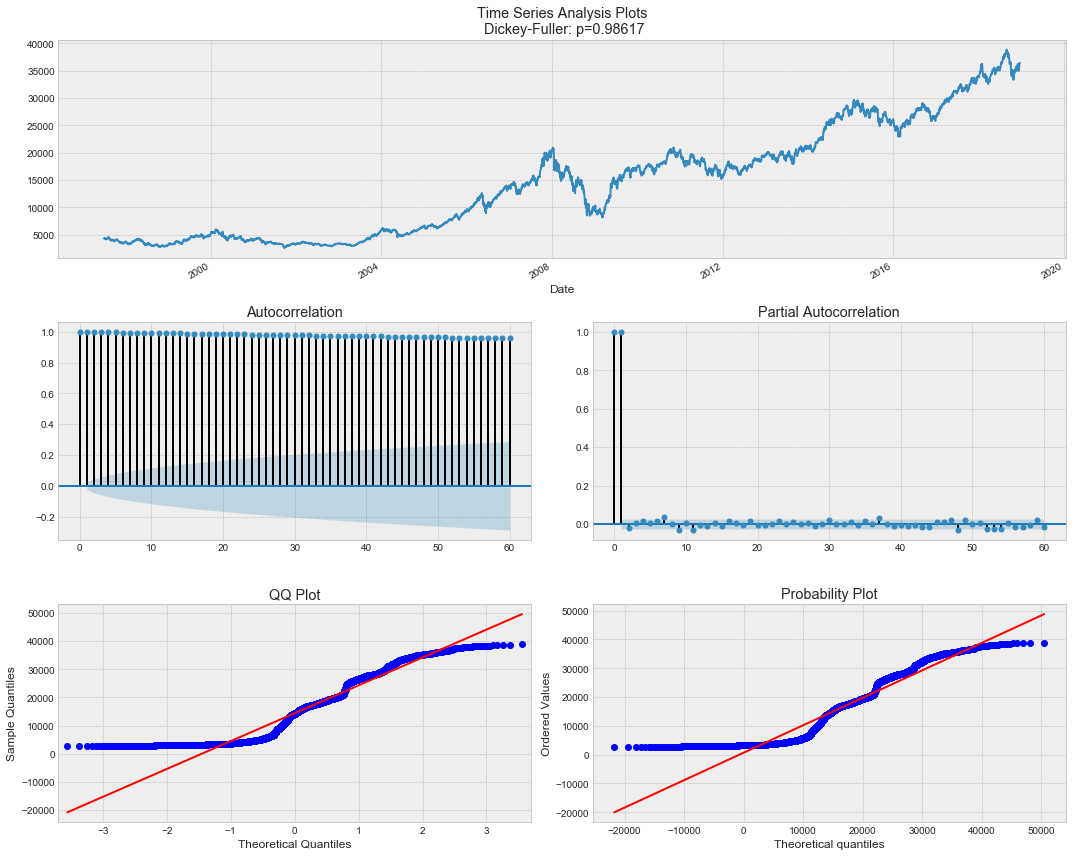

In [33]:
tsplot(new_data.Close, lags=60)

This first plot tells us a lot of things:

1. First of all Dickey Fuller test tells us that this is not a stationary time series (no prizes for guessing)
2. ACF and PACF plots show that autocorrelation is extremely high for almost all lags.
3. QQ plots and Prob Plot also show that data is not normally distributed.

Before we do anything on our time series data, we need to straighten this out which means we need to make it stationary as much as possible and normalize the data. This perhaps will take care of autocorrelations in the data.

So, lets first create lags and calculate these lagged observations from the original data. This is the most common method to make the time series stationary.

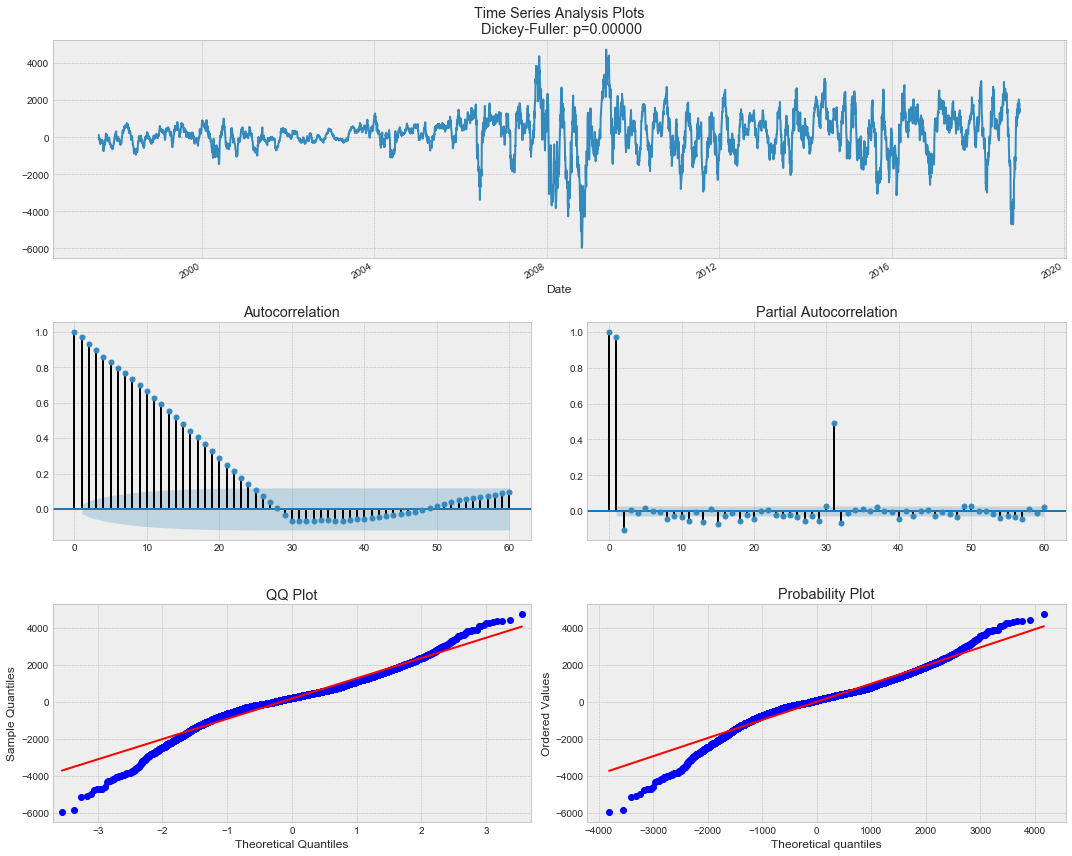

In [34]:
close_diff = new_data.Close - new_data.Close.shift(30)
tsplot(close_diff[30:], lags=60)

Quite Cool!

Dickey Fuller test is now saying our time series is almost stationary (same is reflected in QQ plot and Prob plot).

But ACF and PACF plots show that autocorrelations have not been removed completely.

This means we have some seasonaility effect in the time series. Lets remove this as follows:

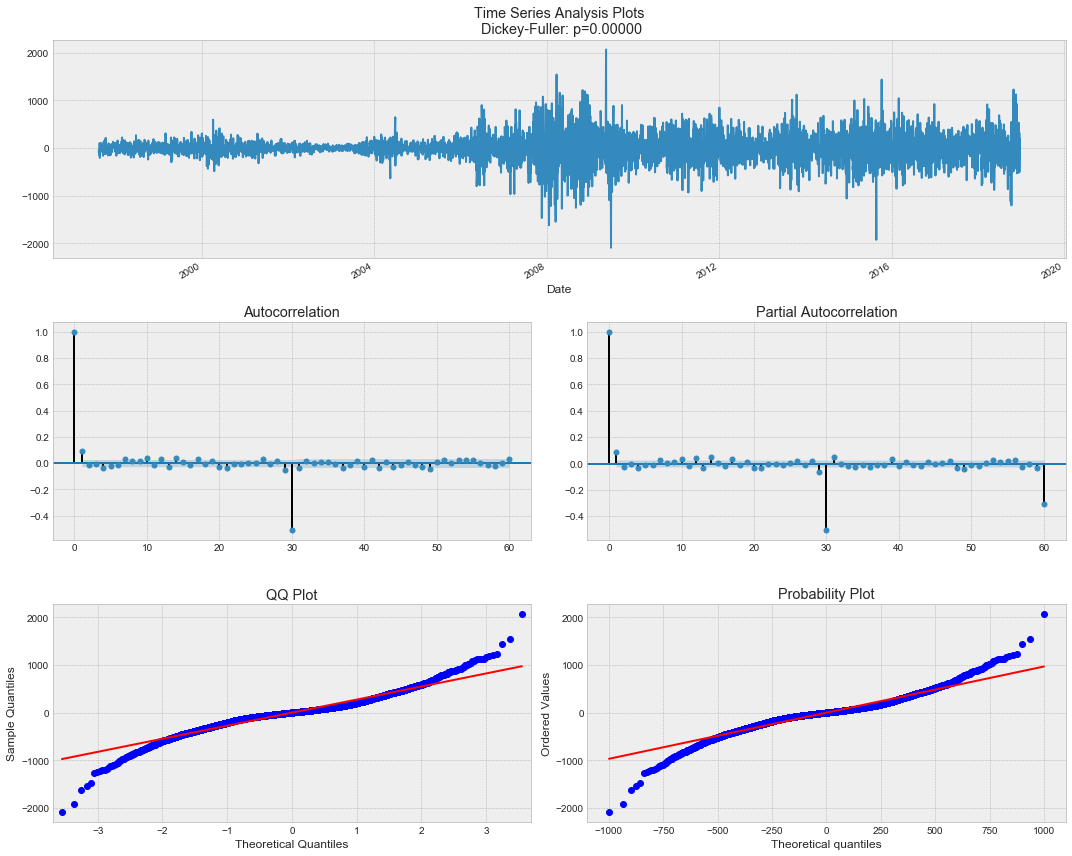

In [35]:
close_diff = close_diff - close_diff.shift(1)
tsplot(close_diff[30+1:], lags=60)

Nice!

So, we have straightend the data as much as we could have.

However, instead of choosing the values of parameters through trial and error method, lets use the SARIMAX model (from Statsmodel package) to select the best values of SARIMA model parametes (p, q, D, s) and calculate the predicted values. All of these in following code snippets:

In [36]:
from itertools import product                  
from tqdm import tqdm_notebook

# setting initial values and some bounds for them
ps = range(2,5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = [4,12]

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs, s)
parameters_list = list(parameters)
len(parameters_list)

parameters_list

[(2, 2, 0, 0, 4),
 (2, 2, 0, 0, 12),
 (2, 2, 0, 1, 4),
 (2, 2, 0, 1, 12),
 (2, 2, 1, 0, 4),
 (2, 2, 1, 0, 12),
 (2, 2, 1, 1, 4),
 (2, 2, 1, 1, 12),
 (2, 3, 0, 0, 4),
 (2, 3, 0, 0, 12),
 (2, 3, 0, 1, 4),
 (2, 3, 0, 1, 12),
 (2, 3, 1, 0, 4),
 (2, 3, 1, 0, 12),
 (2, 3, 1, 1, 4),
 (2, 3, 1, 1, 12),
 (2, 4, 0, 0, 4),
 (2, 4, 0, 0, 12),
 (2, 4, 0, 1, 4),
 (2, 4, 0, 1, 12),
 (2, 4, 1, 0, 4),
 (2, 4, 1, 0, 12),
 (2, 4, 1, 1, 4),
 (2, 4, 1, 1, 12),
 (3, 2, 0, 0, 4),
 (3, 2, 0, 0, 12),
 (3, 2, 0, 1, 4),
 (3, 2, 0, 1, 12),
 (3, 2, 1, 0, 4),
 (3, 2, 1, 0, 12),
 (3, 2, 1, 1, 4),
 (3, 2, 1, 1, 12),
 (3, 3, 0, 0, 4),
 (3, 3, 0, 0, 12),
 (3, 3, 0, 1, 4),
 (3, 3, 0, 1, 12),
 (3, 3, 1, 0, 4),
 (3, 3, 1, 0, 12),
 (3, 3, 1, 1, 4),
 (3, 3, 1, 1, 12),
 (3, 4, 0, 0, 4),
 (3, 4, 0, 0, 12),
 (3, 4, 0, 1, 4),
 (3, 4, 0, 1, 12),
 (3, 4, 1, 0, 4),
 (3, 4, 1, 0, 12),
 (3, 4, 1, 1, 4),
 (3, 4, 1, 1, 12),
 (4, 2, 0, 0, 4),
 (4, 2, 0, 0, 12),
 (4, 2, 0, 1, 4),
 (4, 2, 0, 1, 12),
 (4, 2, 1, 0, 4),
 (4, 2, 1, 0, 12),
 

In [37]:
def optimizeSARIMA(parameters_list, d, D):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(new_data.Close, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], param[4])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [38]:
%%time
import warnings
warnings.filterwarnings('ignore')
result_table = optimizeSARIMA(parameters_list, d, D)
result_table.parameters[0]


Wall time: 30min 1s


In [39]:
# set the parameters that give the lowest AIC
p, q, P, Q, s = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(new_data.Close, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Close   No. Observations:                 5293
Model:             SARIMAX(2, 1, 4)x(1, 1, 1, 12)   Log Likelihood              -35291.399
Date:                            Sat, 22 Dec 2018   AIC                          70600.798
Time:                                    23:17:13   BIC                          70659.943
Sample:                                         0   HQIC                         70621.471
                                           - 5293                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4264      0.007   -213.993      0.000      -1.440      -1.413
ar.L2         -0.9904      0.007   

Quite Cool!

The summary report created by the SARIMAX model is very informative. Probability values tell us that all these lags are quite important for our time series data.

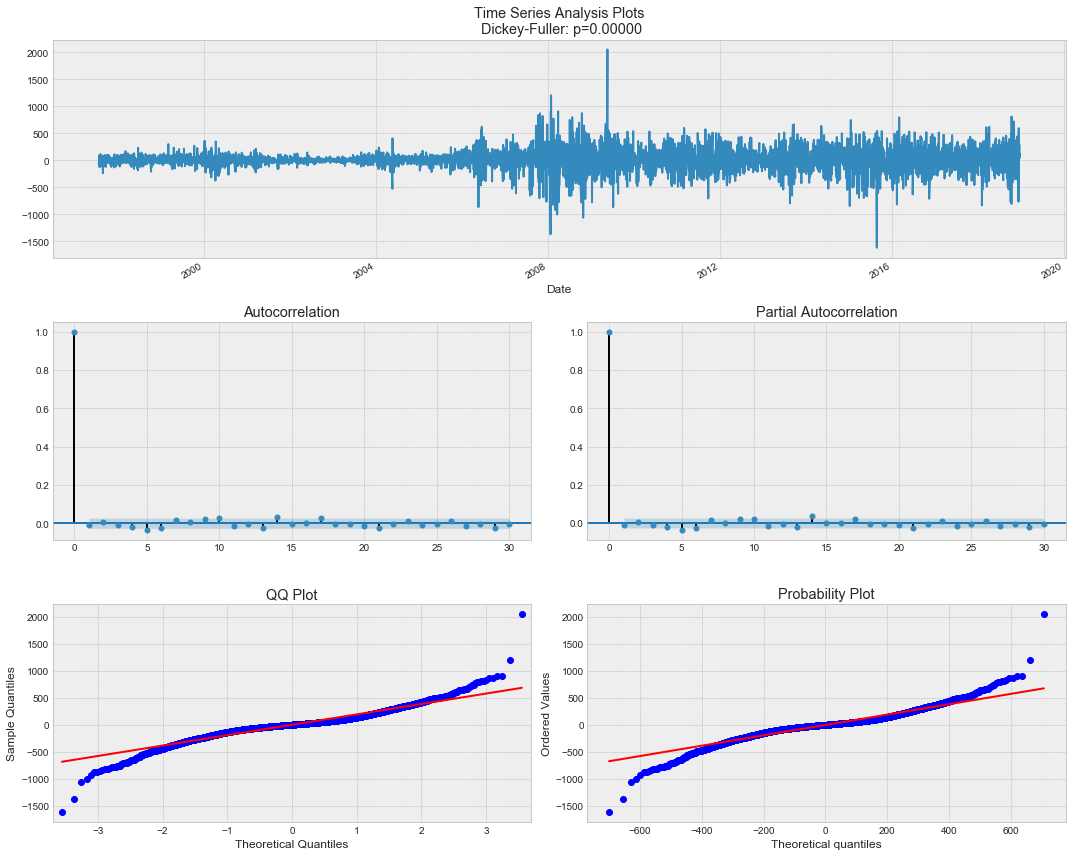

In [40]:
tsplot(best_model.resid[12+1:], lags=30)

Above is the plot on the best model selected by SARIMAX model. We can see that on its own, it has straightened the data. Made it stationary and removed the autocorrelations.

These are best fitted values (predicted values) given by our model. Very soon we will define the loss metric and see how did this fare in terms of prediction.

In [41]:
best_model.fittedvalues[0:5]

Date
1997-07-01       0.000000
1997-07-02    4314.376223
1997-07-03    4331.567835
1997-07-04    4322.749392
1997-07-07    4324.218051
dtype: float64

Can we run some more diagnostics on our best model? Yes, we can! Here it is easy way to see everything at one go:

1. Residual errors are now almost normalized.
2. However, these are still not white noise. Remember, residual errors need to behave like white noise in the data. Otherwise, errors can distort the overall model.

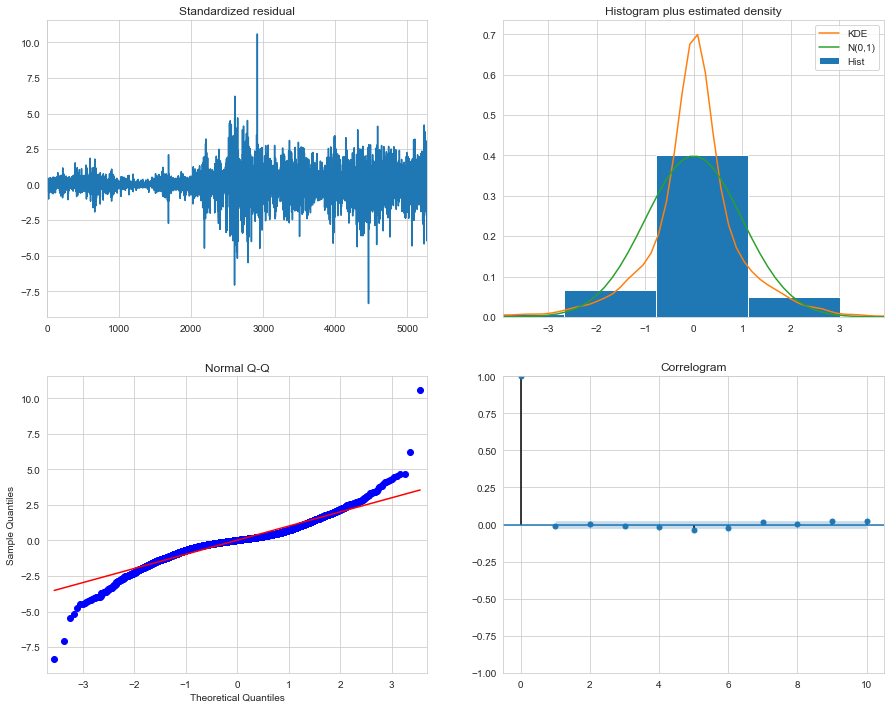

In [42]:
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

We will see now how our best SARIMA model fared in prediction

In [43]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['Close']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['Close'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [44]:
# Lets create a new dataset in which we will only store the required inputs.

#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d %H:%M:%S.%f')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data_arima = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data_arima['Date'][i] = data['Date'][i]
    new_data_arima['Close'][i] = data['Adj Close'][i]

In [45]:
new_data_arima.set_index('Date', inplace=True)

new_data_arima.info()

new_data_arima['Close'] = new_data_arima['Close'].astype(np.int64)

new_data_arima['arima_model'] = best_model.fittedvalues
new_data_arima['arima_model'][:s+d] = np.NaN

forecast = best_model.predict(start = new_data_arima.shape[0], end = new_data_arima.shape[0]+50)
forecast = new_data_arima.arima_model.append(forecast)

# Defining Mean Abs Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error = mean_absolute_percentage_error(new_data_arima['Close'][s+d:], new_data_arima['arima_model'][s+d:])
error

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5293 entries, 1997-07-01 to 2018-12-19
Data columns (total 1 columns):
Close    5293 non-null object
dtypes: object(1)
memory usage: 82.7+ KB


1.0558471494725157

We defined a very simple loss metric above - Mean Absolute Percentage Error which is defined as absolute difference between true values and predicted values and converted into percentage. So lower this value, the better our prediction. 

As you can see, our model has predicted the values quite well. Just around 1% error.

Below are few values where Actual (Close) and Predicted (arima_model) are shown for recent dates. 

Impressed?

In [46]:
new_data_arima.tail(20)

,Close,arima_model
Date,,
2018-11-21,35199,35462.046612
2018-11-22,34981,35186.039121
2018-11-26,35354,34961.006265
2018-11-27,35513,35396.787070
2018-11-28,35716,35522.102799
2018-11-29,36170,35727.578224
2018-11-30,36194,36218.253459
2018-12-03,36241,36204.344746
2018-12-04,36134,36245.287138


In [47]:
new_data_arima.arima_model[s+d:]

Date
1997-07-18     4200.527182
1997-07-21     4112.426419
1997-07-22     4161.006554
1997-07-23     4156.197363
1997-07-24     4272.926704
1997-07-25     4316.702711
1997-07-28     4152.204444
1997-07-29     4132.719501
1997-07-30     4132.115230
1997-07-31     4245.848603
1997-08-01     4284.738614
1997-08-04     4501.794991
1997-08-05     4441.282468
1997-08-06     4569.519067
1997-08-07     4532.564171
1997-08-08     4457.193130
1997-08-11     4389.314212
1997-08-12     4517.832821
1997-08-13     4399.106801
1997-08-14     4360.552551
1997-08-19     4284.852546
1997-08-20     4184.388651
1997-08-21     4248.957737
1997-08-22     4284.740294
1997-08-26     4047.828238
1997-08-27     4112.476044
1997-08-28     4080.619990
1997-08-29     3943.467049
1997-09-01     3898.677474
1997-09-02     3951.047865
                  ...     
2018-11-06    34899.605031
2018-11-07    34998.229216
2018-11-09    35255.396122
2018-11-12    35154.299656
2018-11-13    34779.435962
2018-11-14    35187.096

Plot to show the actual values and predicted values together over the years. The plots coincide with each other so well, we cant even see two plots (but believe me, there are two curves in below plot (one green and one red)

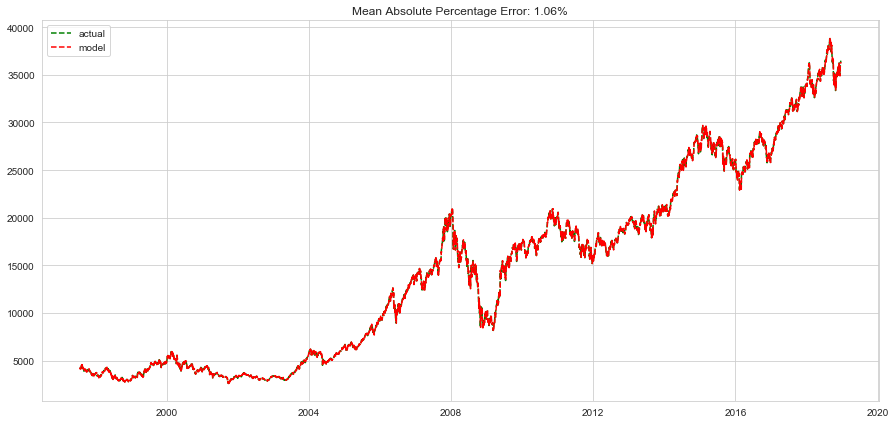

In [48]:
plt.figure(figsize=(15, 7))
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
plt.plot(new_data_arima.Close[s+d:], 'g--', label="actual")
plt.plot(new_data_arima.arima_model[s+d:], 'r--', label="model")
#plt.axvspan(new_data_arima.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.legend()
plt.grid(True);

In [49]:
new_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,5293.0,14390.643911,9891.826244,2600.120117,4578.490234,14282.719727,20193.349609,38896.628906
year,5293.0,2007.709616,6.199668,1997.000000,2002.000000,2008.000000,2013.000000,2018.000000
month,5293.0,6.580956,3.426161,1.000000,4.000000,7.000000,10.000000,12.000000
day_week,5293.0,1.989231,1.411297,0.000000,1.000000,2.000000,3.000000,4.000000
quarter,5293.0,2.524655,1.109469,1.000000,2.000000,3.000000,4.000000,4.000000
week,5293.0,26.825808,14.962762,1.000000,14.000000,27.000000,40.000000,53.000000
quarter_start,5293.0,0.008880,0.093821,0.000000,0.000000,0.000000,0.000000,1.000000
quarter_end,5293.0,0.011147,0.104998,0.000000,0.000000,0.000000,0.000000,1.000000
month_start,5293.0,0.028717,0.167026,0.000000,0.000000,0.000000,0.000000,1.000000
month_end,5293.0,0.033251,0.179309,0.000000,0.000000,0.000000,0.000000,1.000000


Now my favourite part.

Can we use some basic ML algorithms such as Linear Regression / Regularized Regressions to predict the values.

But before that we will do some basic exercises on data.

## Creating features for ML

In [50]:
# Lags for 1 to 22
for i in range(1,22):
        new_data["lag_{}".format(i)] = new_data.Close.shift(i)

In [51]:
new_data.head()

,Close,year,month,day_week,quarter,week,quarter_start,quarter_end,month_start,month_end,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
Date,,,,,,,,,,,,,,,,,,,,,
1997-07-01,4300.859863,1997,7,1,3,27,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-02,4333.899902,1997,7,2,3,27,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-03,4323.459961,1997,7,3,3,27,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-04,4323.819824,1997,7,4,3,27,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-07,4291.450195,1997,7,0,3,28,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Lets create dummies for categorical features

cols = ['year', 'month', 'day_week', 'quarter', 'week', 
        'quarter_start', 'quarter_end', 'week_year', 'mon_fri', 'year_start', 'year_end',
       'month_start', 'month_end', 'day_month', 'half_year']

for i in cols:
    new_data = pd.concat([new_data.drop([i], axis=1), 
        pd.get_dummies(new_data[i], prefix=i)
    ], axis=1)

In [53]:
# Droping NAs if any and re-indexing again

new_data = new_data.dropna()
new_data = new_data.reset_index(drop=True)

new_data.head()

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,month_start_0,month_start_1,month_end_0,month_end_1,day_month_28,day_month_29,day_month_30,day_month_31,half_year_0,half_year_1
0,4244.890137,4217.580078,4181.479980,4189.810059,4226.370117,4251.129883,4186.290039,4154.279785,4124.810059,4193.609863,...,1,0,1,0,0,0,0,1,0,1
1,4305.759766,4244.890137,4217.580078,4181.479980,4189.810059,4226.370117,4251.129883,4186.290039,4154.279785,4124.810059,...,1,0,0,1,0,0,0,1,0,1
2,4347.319824,4305.759766,4244.890137,4217.580078,4181.479980,4189.810059,4226.370117,4251.129883,4186.290039,4154.279785,...,0,1,1,0,0,0,0,1,0,1
3,4465.370117,4347.319824,4305.759766,4244.890137,4217.580078,4181.479980,4189.810059,4226.370117,4251.129883,4186.290039,...,1,0,1,0,0,0,0,1,0,1
4,4548.020020,4465.370117,4347.319824,4305.759766,4244.890137,4217.580078,4181.479980,4189.810059,4226.370117,4251.129883,...,1,0,1,0,0,0,0,1,0,1


In [54]:
new_data.shape

(5272, 191)

In [55]:
# Target Variable
y = new_data.Close.values
type(y)

numpy.ndarray

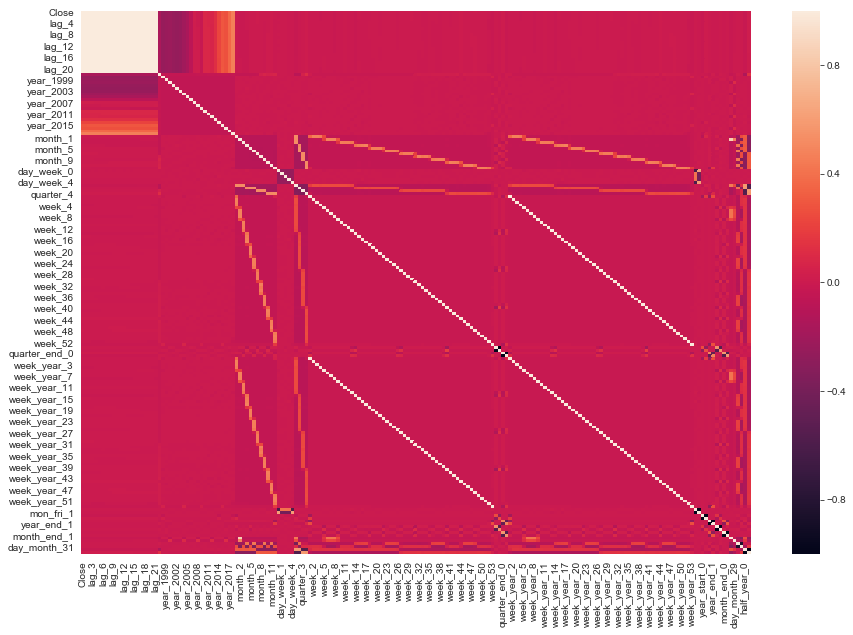

In [56]:
plt.figure(figsize=(15,10))
sns.heatmap(new_data.corr())

Done!

We will now split the data into train and test.

Just to make sure that we dont peep into immediate future, we will stop training data 5 days ago. 30% of our data is held out for test purposes and we will train our model on only 70% of the data. It is very important to remember that in case of timeseries data, the split of train and test can only be done if the dates are sorted in ascending order. Otherwise our test data may contain dates from past and training data may contain the dates from future.

## Splitting the train and test & Feature Scaling

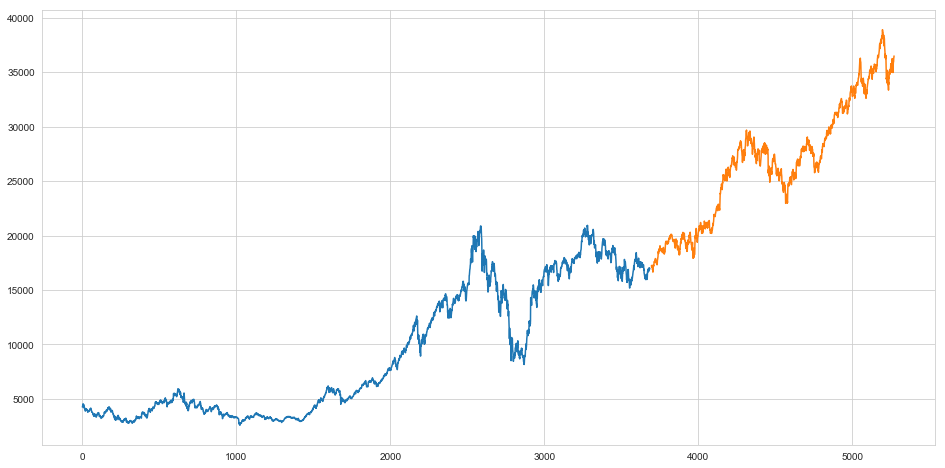

In [57]:
test_index = int(len(new_data) * (1 - 0.30))
test_index

#Since we dont want to look into immediate future, we are creating a window of 10 days. 
#This means, training data will stop at day x-5 and test data will start at x+5.

# splitting whole dataset on train and test

X_train = new_data.loc[:test_index-5].drop(['Close'], axis=1)
y_train = new_data.loc[:test_index-5]["Close"]
X_test = new_data.loc[test_index+5:].drop(["Close"], axis=1)
y_test = new_data.loc[test_index+5:]["Close"]  

# Lets visualize the train and test data together
plt.figure(figsize=(16,8))
plt.plot(y_train)
plt.plot(y_test)

Above pic is quite nice. Blue curve is the one where we will train our model and see if our model can predict the unseen (by the model) test data reflected in orange here.

But before that two important aspects of modelling:

1. We will scale the data. Data without scaling does not fare well for regression models.
2. We will define three Loss Metrics:

   a. MAE - mean absolute error
   
   b. MAPE - mean absolute percentage error (we created this on our own here as sklearn does not have this)
   
   c. MASE - mean absolute scaled error (I copied the code from GitHub)

# Scaling the Data

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Loss Metrics

There are two Loss Metrics which we will use hereafter:

1. Mean Absolute Error (MAE) which is defined as **abs[(y_true - y_pred)/y_true]**
2. Mean Absoloute Percentage Error (MAPE) which is MAE in percentage.
3. Mean Scaled Absolute Error (MASE)

Since there are no sk-learn libraries for MAPE / MASE, we will create our own.


In [59]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import numpy as np


def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

## Cross Validation

For Cross Validation (CV) on Time Series data, we will use **TimeSeries Split** for CV

In [60]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=5)

## Some Custom Modules

In [61]:
def plotModelResults(model, df_train, df_test, y_train, y_test, plot_intervals=False, plot_anomalies=False, scale=1.96, cv=tscv):
    """
    Plots modelled vs fact values
    
    model: fitted model 
    
    df_train, df_test: splitted featuresets
    
    y_train, y_test: targets
    
    plot_intervals: bool, if True, plot prediction intervals
    
    scale: float, sets the width of the intervals
    
    cv: cross validation method, needed for intervals
    
    """
    # making predictions for test
    prediction = model.predict(df_test)
    
    plt.figure(figsize=(20, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        # calculate cv scores
        cv = cross_val_score(
            model, 
            df_train, 
            y_train, 
            cv=cv, 
            scoring="neg_mean_squared_error"
        )

        # calculate cv error deviation
        deviation = np.sqrt(cv.std())
        
        # calculate lower and upper intervals
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
        
    # calculate overall quality on test set
    mae  = mean_absolute_error(prediction, y_test)
    mape = mean_absolute_percentage_error(prediction, y_test)
    mase = MASE(y_train, y_test, prediction)
    plt.title("MAE {}, MASE {}, MAPE {}%".format(round(mae), round(mase), round(mape, 2)))
    plt.legend(loc="best")
    plt.grid(True);

Another plotting module for Coefficients

In [62]:
def getCoefficients(model):
    """Returns sorted coefficient values of the model"""
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1) 

In [63]:
def plotCoefficients(model):
    """Plots sorted coefficient values of the model"""
    coefs = getCoefficients(model)
    
    plt.figure(figsize=(20, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.show()

So, time for first ML model

## Linear Regression

In [64]:
# First we will use the simplest of them all - Linear Regression
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Let's see Mean Absolute Error for our simplest model.

In [65]:
cv = cross_val_score(lr, X_train_scaled, y_train, scoring = 'neg_mean_absolute_error', cv=tscv)
mae = cv.mean()*(-1)
mae

1318634337194484.8

Oh Gosh!

Linear Regression did not fare well at all on the prediction. I cant even count the number in error!

Let's see the plot for Linear Regression

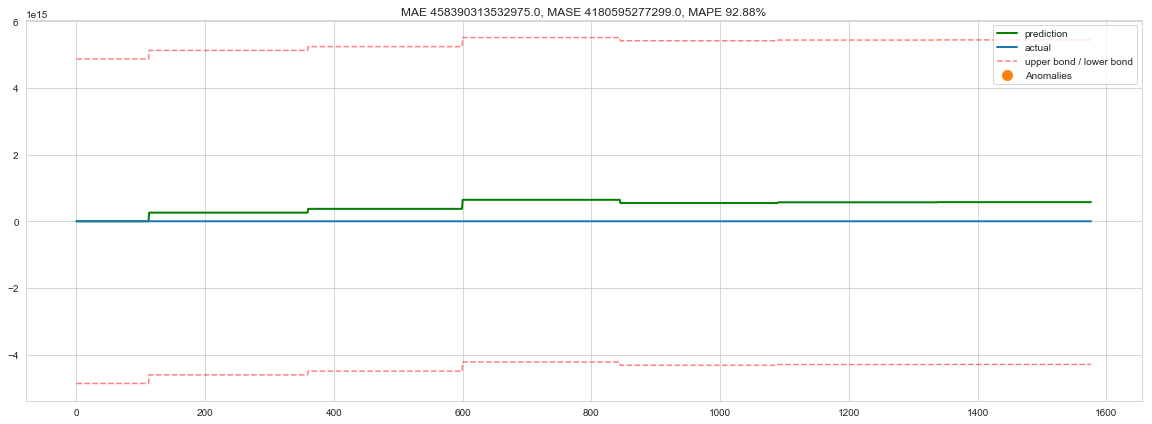

In [66]:
plotModelResults(lr, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)

This plot does not tell us much apart from the fact that our model has faired poorly in predicting the pattern.

Lets see the plot for coefficients

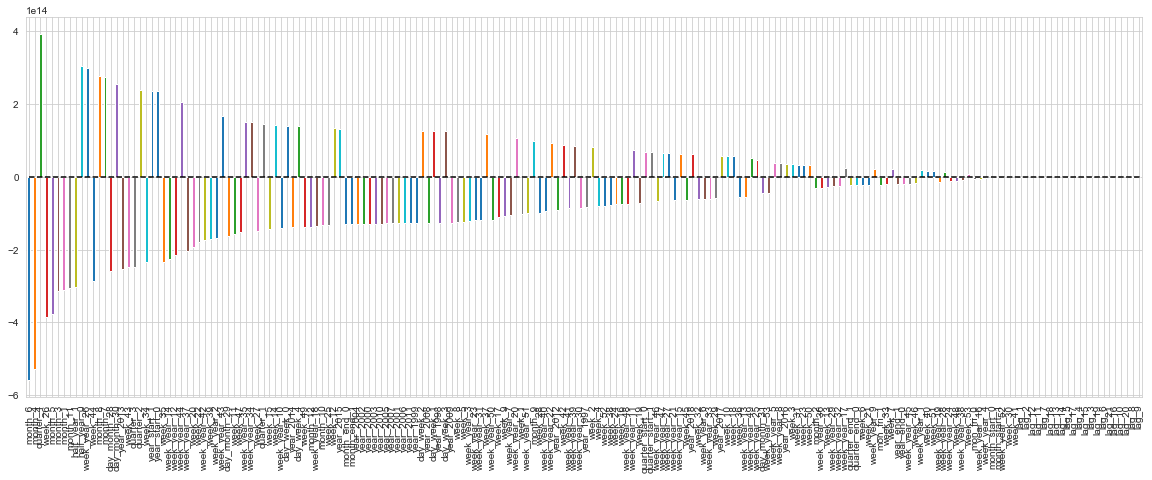

In [67]:
plotCoefficients(lr)

Lets create our next model - Lasso Regression

## Lasso Regression

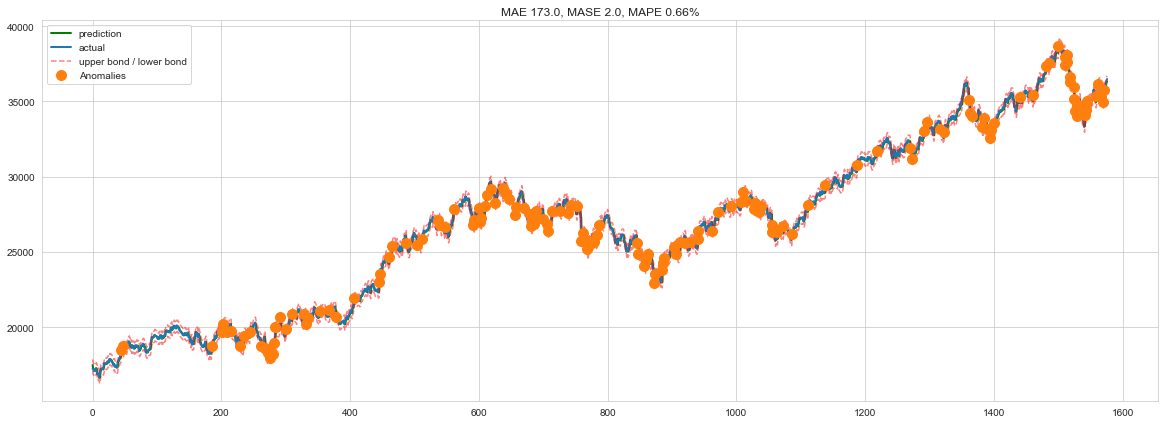

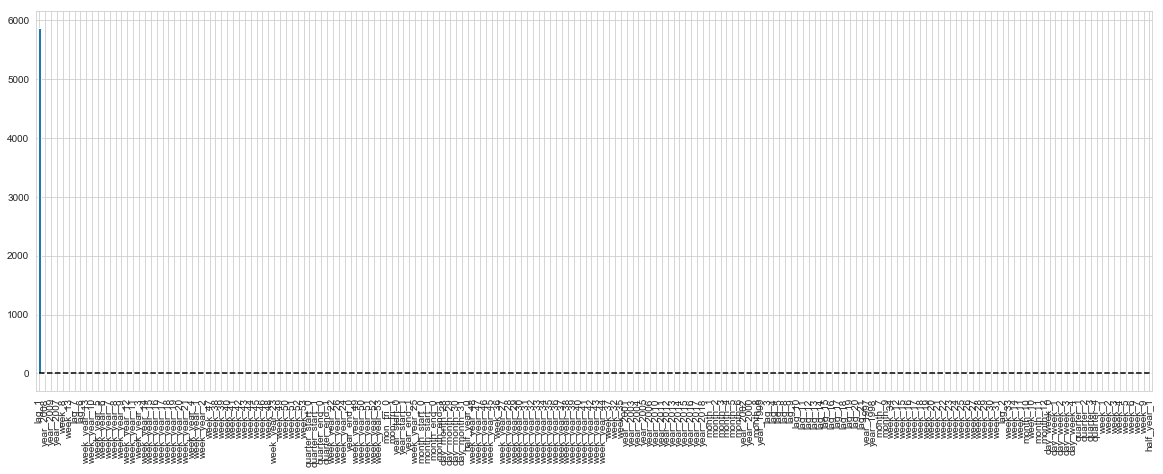

In [68]:
lasso = LassoCV(cv =tscv, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train_scaled, 
                 X_test_scaled,
                 y_train, 
                 y_test,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

SUPER!

This has turned out to be the best so far. MAPE of around 0.5%. This is pretty awesome.

Lets see which are the features our super-hero Lasso has selected

In [69]:
coef = getCoefficients(lasso)
np.count_nonzero(np.where(coef['coef']==0.000000))

coef.sort_values(by='coef', ascending=False).head(10)

,coef
lag_1,5.874198e+03
year_2009,3.133052e+00
year_2007,2.269415e+00
week_13,4.265783e-01
lag_7,3.913655e-01
lag_6,3.881142e-01
week_year_13,1.973944e-15
year_1999,-0.000000e+00
lag_13,0.000000e+00
lag_3,0.000000e+00


No surprizes.

Lag 1 is the most important feature. But apart from that, year 2007, 2009 (before and after the year of financial crisis) are also turned out to be important features.

Now lets see some more plots

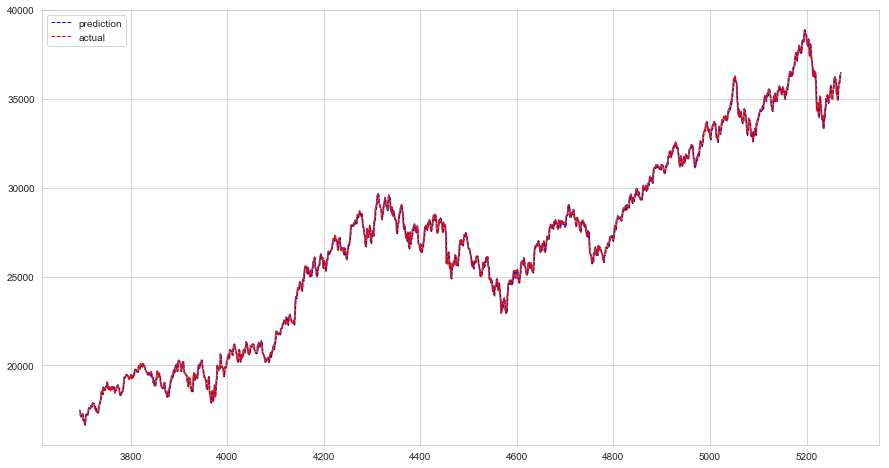

In [70]:
from sklearn.linear_model import Lasso
lasso = Lasso(max_iter=10000, random_state=17)

lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

columns = ['Close_actual', 'Close_pred']
df_pred_lasso = pd.DataFrame(columns = columns)

df_pred_lasso.Close_actual = y_test
df_pred_lasso.Close_pred = y_pred

plt.figure(figsize=(15,8))
plt.plot(df_pred_lasso)
plt.plot(df_pred_lasso.Close_pred, "b--", label="prediction", linewidth=1.0)
plt.plot(df_pred_lasso.Close_actual, "r--", label="actual", linewidth=1)
plt.legend(loc="best")

In [71]:
df_pred_lasso['diff'] = df_pred_lasso.Close_actual - df_pred_lasso.Close_pred
df_pred_lasso['perc_diff'] = ((df_pred_lasso['diff']) / (df_pred_lasso['Close_pred']))

df_pred_lasso.head(20)

,Close_actual,Close_pred,diff,perc_diff
3695,17232.550781,17490.053179,-257.502398,-0.014723
3696,17213.699219,17240.191903,-26.492684,-0.001537
3697,17103.310547,17226.221049,-122.910502,-0.007135
3698,17105.300781,17116.020178,-10.719397,-0.000626
3699,17185.009766,17125.138578,59.871188,0.003496
3700,17278.849609,17192.180897,86.668712,0.005041
3701,17158.439453,17289.152257,-130.712804,-0.007560
3702,16877.349609,17168.899432,-291.549823,-0.016981
3703,16918.080078,16889.049721,29.030357,0.001719
3704,16846.050781,16936.358149,-90.307368,-0.005332


You can see the actual values and predicted values. This gets close to almost equal. 

Lets see how does Ridge regression fare on this timeseries data

## Ridge Regression

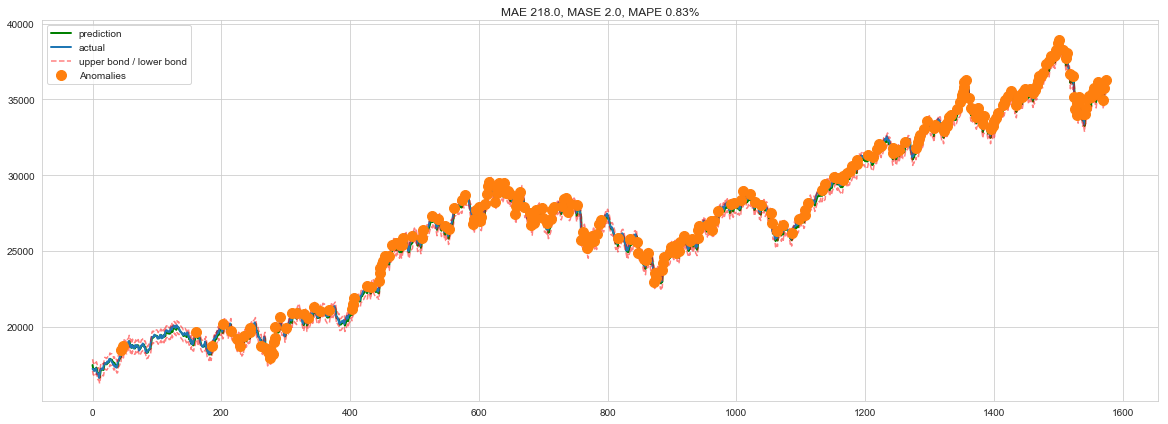

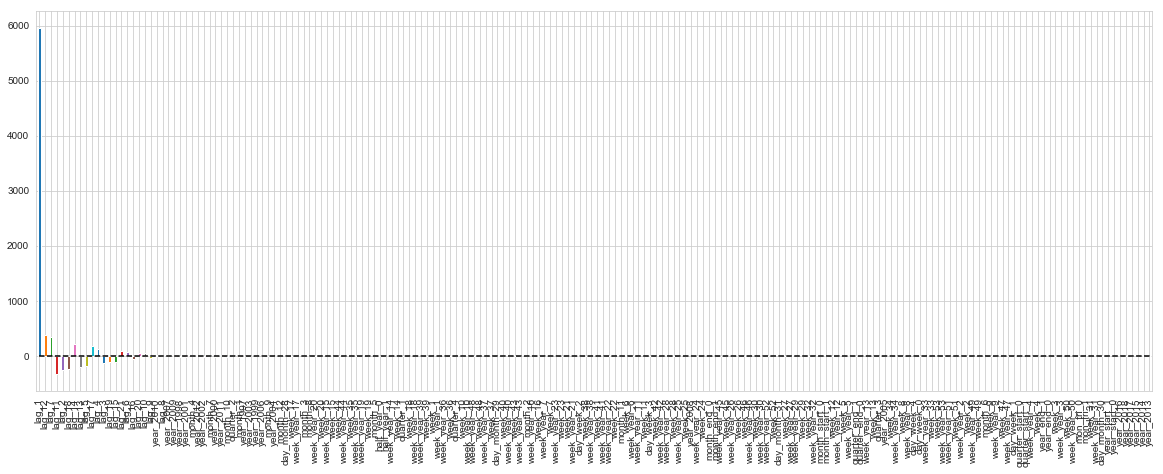

In [72]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(max_iter=10000, random_state=17)

ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)

columns = ['Close_actual', 'Close_pred']
df_pred_ridge = pd.DataFrame(columns = columns)

df_pred_ridge.Close_actual = y_test
df_pred_ridge.Close_pred = y_pred

plt.figure(figsize=(15,8))
plt.plot(df_pred_ridge)
plt.plot(df_pred_ridge.Close_pred, "b--", label="prediction", linewidth=1.0)
plt.plot(df_pred_ridge.Close_actual, "r--", label="actual", linewidth=1.0)
plt.legend(loc="best")

In [ ]:
df_pred_ridge['diff'] = df_pred_ridge.Close_actual - df_pred_ridge.Close_pred
df_pred_ridge['perc_diff'] = ((df_pred_ridge['diff']) / (df_pred_ridge['Close_pred']))*100
df_pred_ridge.head(20)

Quite well. This is almost same performance as Lasso!

Now lets use some dimensionality reduction techniques and see if we can improve the model

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

def plotPCA(pca):
    """
    Plots accumulated percentage of explained variance by component
    
    pca: fitted PCA object
    """
    components = range(1, pca.n_components_ + 1)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.figure(figsize=(20, 10))
    plt.bar(components, variance)
    
    # additionally mark the level of 95% of explained variance 
    plt.hlines(y = 95, xmin=0, xmax=len(components), linestyles='dashed', colors='red')
    
    plt.xlabel('PCA components')
    plt.ylabel('variance')
    plt.xticks(components)
    plt.show()

In [ ]:
# Create PCA object: pca
pca = PCA()

# Train PCA on scaled data
pca = pca.fit(X_train_scaled)

# plot explained variance
plotPCA(pca)

In [ ]:
pca_comp = PCA(0.95).fit(X_train_scaled)
print('We need only %d components to explain 95%% of variance' 
      % pca_comp.n_components_)

In [ ]:
pca = PCA(n_components=pca_comp.n_components).fit(X_train_scaled)

pca_features_train = pca.transform(X_train_scaled)
pca_features_test = pca.transform(X_test_scaled)

Lets run the Linear Regression model once again to see if there are any improvements since last time

In [ ]:
lr.fit(pca_features_train, y_train)

plotModelResults(lr, pca_features_train, pca_features_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)

Ok, so linear regression improved a lot! Now Lets see how Lasso and Ridge are performing on PCA transformed data

In [ ]:
from sklearn.linear_model import Lasso
Lasso = Lasso(max_iter=10000)
Lasso.fit(pca_features_train, y_train)

from sklearn.linear_model import Ridge
ridge = Ridge(max_iter=10000, random_state=17)
ridge.fit(pca_features_train, y_train)

In [ ]:
plotModelResults(Lasso, pca_features_train, pca_features_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)

In [ ]:
plotModelResults(ridge, pca_features_train, pca_features_test, y_train, y_test, plot_intervals=True, plot_anomalies=True)

But PCA actually deteriorated the performance of Lasso and Ridge

We will now use a very popular ML method to predict timeseries values - Facebook Prophet. It was released in year 2017 for public by Facebook which they had been using internally over the years for their internal research.

Lets see how does it fare for our problem

## Facebook Prophet

Now lets use FB-Prophet to predict the pattern. But before that, we will make the data suitable for analysis

In [ ]:

from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

df_new = df['Close']

df_new

In [ ]:
# Lets see the monthly pattern over the years
monthly_df = df_new.resample('M').apply(sum)
plt.figure(figsize=(15,10))
plt.plot(monthly_df)

Creating Dataset for FB-Prophet

In [ ]:
df_n = df_new.reset_index()
df_n.columns = ['ds', 'y']
df_n = df_n.reset_index(drop=True)

In [ ]:
prediction_size = 30 # prediction for one-month
train_df = df_n[:-prediction_size]
train_df.tail(n=3)

Fitting the model and Creating Future Dataframes including the history

In [ ]:
m = Prophet()
m.fit(train_df);

In [ ]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

In [ ]:
forecast = m.predict(future)
forecast.tail(n=3)

Creating Plots to see the patterns predicted by FB-Prophet

In [ ]:
m.plot(forecast)

In [ ]:
m.plot_components(forecast)

Prophet has some nice plot features which are quite obvious easy to read and interpret.

Lets combine Historic and Forecast data together

In [ ]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

cmp_df = make_comparison_dataframe(df_n, forecast)
cmp_df.tail(n=3)

In [ ]:
prediction_size=10 # 10 days prediction
cmp_df_pred = cmp_df[-prediction_size:]
cmp_df_pred['MAE'] = cmp_df_pred['y'] - cmp_df_pred['yhat']
cmp_df_pred['MAPE'] = 100* cmp_df_pred['MAE'] / cmp_df_pred['y']

print('average MAE:', np.mean(np.abs(cmp_df_pred['MAE'])))
print('average MAPE:', np.mean(np.abs(cmp_df_pred['MAPE'])))

So, FB Prophet has not performed better than Lasso and Regression. This may be because data is not normal. We can normalize the data through Box Cox transformation.

## Box Cox Transformation

In [ ]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

train_df2 = train_df.copy().set_index('ds')

from scipy import stats
import statsmodels.api as sm
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)
train_df2.head(3)

In [ ]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

In [ ]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

Plotting the new components 

In [ ]:
m2.plot(forecast2)

In [ ]:
m2.plot_components(forecast2)

Lets create a module for forecast errors

In [ ]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [ ]:
cmp_df2 = make_comparison_dataframe(df_n, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

cmp_df2.tail(20)

Quite Close to our Lasso and Ridge predictions in terms of MAPE errors. However, FB Prophet has not fared well in comparison with Lasso and Ridge (see predicted results are very far from actual values).

Now lets run 2 very powerful algorithms (XGB and LGB) and see if they can beat Lasso and Ridge. 

## XGBoost

In [ ]:
import sys
#sys.path.append('/Users/dmitrys/xgboost/python-package/')
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)

## Light GBM

In [ ]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(X_train_scaled, y_train)

plotModelResults(lgb, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)

Tree based algorithms are known to fail miserably on time series predictions which is evident from the above results.

Now we will do some stacking and see if results on Lasso and Ridge can be improved further.

Here we will use three classifiers:

1. Elastic Net (base)
2. Ridge (base)
3. Lasso (Meta)

## Stacking the Models

In [ ]:
from mlxtend.classifier import StackingClassifier
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import ElasticNet

clf1 = ElasticNet(max_iter=10000)
clf2 = ridge


sclf = StackingRegressor(regressors=[clf1, clf2], 
                          meta_regressor=lasso)

sclf.fit(X_train_scaled, y_train)


plotModelResults(sclf, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, plot_anomalies=True)

In [ ]:
y_pred = sclf.predict(X_test_scaled)

columns = ['Close_actual', 'Close_pred']
df_pred_sclf = pd.DataFrame(columns = columns)

df_pred_sclf.Close_actual = y_test
df_pred_sclf.Close_pred = y_pred


plt.figure(figsize=(15,8))
plt.plot(df_pred_sclf)
plt.plot(df_pred_sclf.Close_pred, "b--", label="prediction", linewidth=0.5)
plt.plot(df_pred_sclf.Close_actual, "r--", label="actual", linewidth=0.5)
plt.legend(loc="best")

In [ ]:
df_pred_sclf['diff'] = df_pred_sclf.Close_actual - df_pred_sclf.Close_pred
df_pred_sclf['perc_diff'] = ((df_pred_sclf['diff']) / (df_pred_sclf['Close_pred']))*100
df_pred_sclf.head(20)

## Conclusions

There are lots of takeaways:

1. Cracking non-stationary timeseries (specially random walks) is not as difficult as it seems.

2. Lots of it (prediction) depend on lag period.

3. Linear models fare awesomely on these problems.

4. SARIMAX model also did a good job as well as Prophet.

5. Tree based models in timeseries prediction failed miserably.

6. And finally, the most important part - don't use these techniques to predict the returns and later try to find me if something bad happens in the market. This is the only disclaimer I have. Oh yes, one more - this I have written entirely in personal capacity and it has nothing to do with my employer. I submitted a project recently in one of the competitions on the similar project (where I predicted the returns on one of the stocks) and gained a lots of appreciation. So, I thought I will share it with a larger crowd.

Thats it guys!

Thanks so so much for reading it.

Hope all of this makes some sense and can be of some use.

In case of any queries, feedback or comments, please feel free to contact me @ abhikjha@gmail.com